Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline.

V3.1 PID neural network takes in previous y value as parameter

V3.2 Take absolute value of Kp, Ki, Kd

V3.3 PID control the plant while training with a manually tuned PID controller

V3.4 Remove 3.3 changes. Initialize bias term with ones

V3.5 Added another layer to model neural network. Initialized only model nn with zeros. Increased NN model size to 16

V3.6 Changed to Adam Optimizer. Increased model to 3 layers: 16, 8 ,4. Added 10 epochs. Lowered learning rate

V3.7 Allowing model nn weight updates in online training

V3.8 Remove 3.7 changes. Added layer to PID nn: 8, 3. Switched to leaky relu in model nn

V3.9 Model hl: 4, 8, 8, 4. PID hl: 8, 5, 3

(V4.0 LSTM didn't show much difference in model learning)

V3.X.0 Split PID neural network into 3 separate networks

V3.X.1 input error into PID neural network. Switched PID to leaky relu. Modified offline training signal to combine sin and square

V3.X.2 Minimize loss E(y, r, y_m). Rolling offline and online training into online training

V3.X.3 Removed 3.X.2 changes. Changed gain update to delta. Fixed resetting y_0. Fixed PID update (e was not self.e)

V3.X.4 Removed delta gain update. Use learned PID in offline training. Reduced steps by half.

V3.X.5 Removed 3.X.0 changes

V3.X.6 Removed 3.X.5 changes. Removed limit on I term

V3.X.7 Use difference between plant and model as PID nn input

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 1500

In [3]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
#         self.I_max = 20
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp=None, Ki=None, Kd=None):
        if Kp is not None and Ki is not None and Kd is not None:
            self.Kp = Kp
            self.Ki = Ki
            self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = self.e
        
        self.I += self.e * delta_time

#         if (self.I < -self.I_max):
#             self.I = -self.I_max
#         elif (self.I > self.I_max):
#             self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [4]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

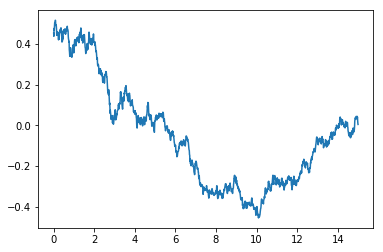

In [5]:
interval = 200
r_steps = steps//interval

r_sq = np.zeros(steps)
up = -1

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

r_combo = np.append(r_sin[:steps//2], r_sq[steps//2:])

### Plant control with neural network

In [6]:
pid = PID(1, 1, 1)

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]

hm1 = 4
hm2 = 8
hm3 = 8
hm4 = 4

hpKp1 = 8
hpKi1 = 8
hpKd1 = 8
hpKp2 = 3
hpKi2 = 3
hpKd2 = 3

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=(), name="r_input")
    tf_u = tf.placeholder(tf.float32,shape=(), name="u_input")
    tf_y = tf.placeholder(tf.float32,shape=(), name="y_plant_input")
    tf_e = tf.placeholder(tf.float32,shape=(), name="e_input")
    tf_y_p_m_diff = tf.placeholder(tf.float32,shape=(), name="y_p_m_diff")
    tf_learning_rate = tf.placeholder(tf.float32, shape=(), name="learn_rate")

              
    # Model NN    
    wm_1 = tf.Variable(tf.truncated_normal([1, hm1]))
    bm_1 = tf.Variable(tf.zeros([hm1]))   
    wm_2 = tf.Variable(tf.truncated_normal([hm1, hm2]))
    bm_2 = tf.Variable(tf.zeros([hm2]))
    wm_3 = tf.Variable(tf.truncated_normal([hm2, hm3]))
    bm_3 = tf.Variable(tf.zeros([hm3]))
    wm_4 = tf.Variable(tf.truncated_normal([hm3, hm4]))
    bm_4 = tf.Variable(tf.zeros([hm4]))
    wm_5 = tf.Variable(tf.truncated_normal([hm4, 1]))
    bm_5 = tf.Variable(tf.zeros([1]))
    
    # PID param NN
    wpid_Kp_1 = tf.Variable(tf.truncated_normal([1, hpKp1]))
    bpid_Kp_1 = tf.Variable(tf.ones([hpKp1]))   
    wpid_Kp_2 = tf.Variable(tf.truncated_normal([hpKp1, hpKp2]))
    bpid_Kp_2 = tf.Variable(tf.ones([hpKp2]))
    wpid_Kp_3 = tf.Variable(tf.truncated_normal([hpKp2, 1]))
    bpid_Kp_3 = tf.Variable(tf.ones([1]))
    
    wpid_Ki_1 = tf.Variable(tf.truncated_normal([1, hpKi1]))
    bpid_Ki_1 = tf.Variable(tf.ones([hpKi1]))   
    wpid_Ki_2 = tf.Variable(tf.truncated_normal([hpKi1, hpKi2]))
    bpid_Ki_2 = tf.Variable(tf.ones([hpKi2]))
    wpid_Ki_3 = tf.Variable(tf.truncated_normal([hpKi2, 1]))
    bpid_Ki_3 = tf.Variable(tf.ones([1]))
    
    wpid_Kd_1 = tf.Variable(tf.truncated_normal([1, hpKd1]))
    bpid_Kd_1 = tf.Variable(tf.ones([hpKd1]))   
    wpid_Kd_2 = tf.Variable(tf.truncated_normal([hpKd1, hpKd2]))
    bpid_Kd_2 = tf.Variable(tf.ones([hpKd2]))
    wpid_Kd_3 = tf.Variable(tf.truncated_normal([hpKd2, 1]))
    bpid_Kd_3 = tf.Variable(tf.ones([1]))

    def model_fp(input_value):
        z1 = tf.matmul(input_value, wm_1) + bm_1
        a1 = tf.nn.leaky_relu(z1)
        
        z2 = tf.matmul(a1, wm_2) + bm_2
        a2 = tf.nn.leaky_relu(z2)
        
        z3 = tf.matmul(a2, wm_3) + bm_3
        a3 = tf.nn.leaky_relu(z3)
        
        z4 = tf.matmul(a3, wm_4) + bm_4
        a4 = tf.nn.leaky_relu(z4)
        
        return tf.matmul(a4, wm_5) + bm_5
        
    
    # Forward prop model offline
    y_model_offline = model_fp(tf.reshape(tf_u, (1, 1)))
 
    def pid_fp(input_value, w1, b1, w2, b2, w3, b3):
        z1 = tf.matmul(input_value, w1) + b1
        a1 = tf.nn.leaky_relu(z1)
        z2 = tf.matmul(a1, w2) + b2
        a2 = tf.nn.leaky_relu(z2)
        return tf.matmul(a2, w3) + b3
    
    # Forward prop PID
#     e_rs = tf.reshape(tf_e, (1, 1))
#     r_rs = tf.reshape(tf_r, (1, 1))
    y_p_m_diff_rs = tf.reshape(tf_y_p_m_diff, (1, 1))
    
    Kp = pid_fp(y_p_m_diff_rs, wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3)
    Ki = pid_fp(y_p_m_diff_rs, wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3)
    Kd = pid_fp(y_p_m_diff_rs, wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3)
    
    Kp_abs = tf.math.abs(Kp)
    Ki_abs = tf.math.abs(Ki)
    Kd_abs = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp_abs, Ki_abs, Kd_abs)
#     u_nn = tf_update(Kp, Ki, Kd)

    
    # Forward prop model online
    y_model_online = model_fp(u_nn)

    
    model_var_list = [wm_1, bm_1, wm_2, bm_2, wm_3, bm_3, wm_4, bm_4, wm_5, bm_5]
    model_loss = tf.losses.mean_squared_error(tf_y, tf.reshape(y_model_offline, ()))
    model_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(model_loss, var_list=model_var_list)

    pid_var_list = [wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3,
                   wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3,
                   wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3]
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model_online, ()))
    pid_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(pid_loss, var_list=pid_var_list)
    
    writer = tf.summary.FileWriter('./graphs', graph)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.


In [7]:
epochs = 10

y_0 = 0
y_p_offline = np.zeros(steps)
y_m_offline = np.zeros(steps)

y_p_online = np.zeros(steps)
y_m_online = np.zeros(steps)
u_offline = np.zeros(steps)
u_online = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

offline_loss = np.zeros(steps * epochs)
online_loss = np.zeros(steps * epochs) 



r_offline = r_sq
r_online = r_sq


offline_lr = 0.01
online_lr = 0.01

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
       
        #OFFLINE
        #Reset values
        y_0 = 0
        y_p_offline = np.zeros(steps)
        y_m_offline = np.zeros(steps)
        u_offline = np.zeros(steps)
        t_prev = 0
        
        print("Start epoch", j)
        for i in range(steps):
            
            e = r_offline[i] - y_0

            t_cur = t[i]
            pid.set_state(e, t_cur)
            u_offline[i] = pid.update()
            # Get plant output
            y_p_offline[i] = plant(y_0, t_prev, t_cur, u_offline)
            
            # Train model on plant output
            feed_dict = {tf_y:y_p_offline[i], tf_u:u_offline[i], tf_learning_rate:offline_lr}
            _, offline_loss[i + j*steps], y_m_offline[i] = session.run([model_opt, model_loss, y_model_offline], 
                                                             feed_dict=feed_dict)

            y_0 = y_p_offline[i]
            t_prev = t[i]
            
        print("Offline loss", sum(offline_loss[j * steps:i + j*steps])/(i + j*steps))
        
        #ONLINE
        #Reset values
        y_0 = 0
        t_prev = 0
        
        y_p_online = np.zeros(steps)
        y_m_online = np.zeros(steps)
        u_online = np.zeros(steps)
        y_p_m_diff = 0
        
        for i in range(steps):  

            e = r_online[i] - y_0

            t_cur = t[i]
            pid.set_state(e, t_cur)

            # Get get PID parameters and get control signal
            # Send to model to train PID param NN
            feed_dict = {tf_y_p_m_diff:y_p_m_diff, tf_r:r_online[i], tf_learning_rate:online_lr}
            _, online_loss[i + j*steps], y_m_online[i], u_online[i] = session.run([pid_opt, 
                                                                                   pid_loss, 
                                                                                   y_model_online, u_nn], 
                                                                                  feed_dict=feed_dict)
            
            y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
            

            y_0 = y_p_online[i]
            t_prev = t[i]
            y_p_m_diff = y_0 - y_m_online[i]
            
        print("Online loss", sum(online_loss[j * steps:i + j*steps])/(i + j*steps))

    #TEST
    #Reset values
    y_0 = 0
    t_prev = 0
    
    y_p_online = np.zeros(steps)
    y_m_online = np.zeros(steps)
    u_online = np.zeros(steps)
    y_p_m_diff = 0

    
    for i in range(len(t)):  
        
        e = r_online[i] - y_0
        
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        feed_dict = {tf_y_p_m_diff:y_p_m_diff, tf_r:r_online[i], tf_learning_rate:online_lr}
        y_m_online[i], u_online[i] = session.run([y_model_online, u_nn], feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
        y_p_online_prev = y_p_online[i]
        
        y_0 = y_p_online[i]
        t_prev = t[i]
        y_p_m_diff = y_0 - y_m_online[i]


Start epoch 0
Offline loss 23.03303214991465
Online loss 0.8253247728871088
Start epoch 1
Offline loss 6.256863408102463
Online loss nan
Start epoch 2
Offline loss nan
Online loss nan
Start epoch 3
Offline loss nan
Online loss nan
Start epoch 4
Offline loss nan
Online loss nan
Start epoch 5
Offline loss nan
Online loss nan
Start epoch 6
Offline loss nan
Online loss nan
Start epoch 7
Offline loss nan
Online loss nan
Start epoch 8
Offline loss nan
Online loss nan
Start epoch 9
Offline loss nan
Online loss nan


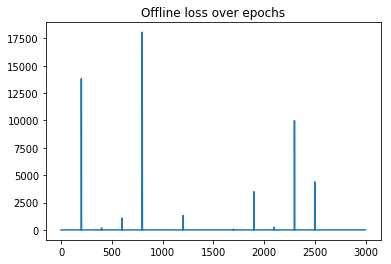

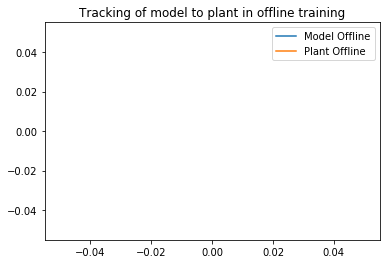

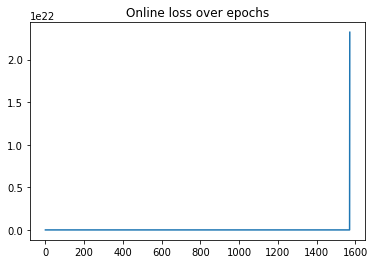

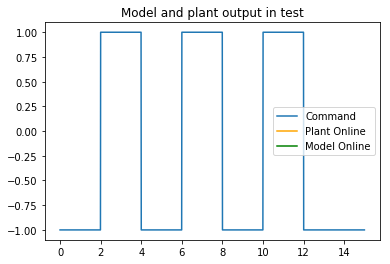

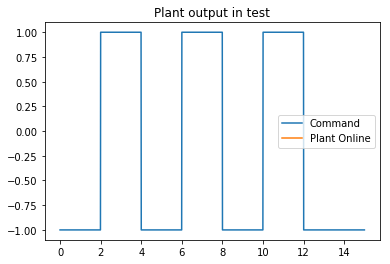

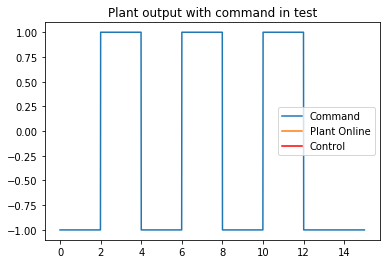

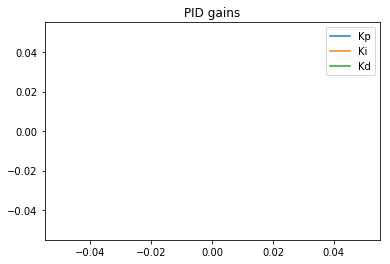

In [8]:
plt.plot(offline_loss)
plt.title('Offline loss over epochs')
plt.show()

plt.plot(t, y_m_offline)
plt.plot(t, y_p_offline)
plt.title('Tracking of model to plant in offline training')
plt.legend(('Model Offline', 'Plant Offline'))
plt.show()

plt.plot(online_loss)
plt.title('Online loss over epochs')
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online, color='orange')
plt.plot(t, y_m_online, color='green')
plt.title('Model and plant output in test')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.title('Plant output in test')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.plot(t, u_online, color='red')
plt.title('Plant output with command in test')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()